# Strategy 1

In this case, we set $f_\phi$ to all the channels.

In [52]:
using PyPlot
using Roots
using NLsolve
using DataFrames
using CSV
using PyCall
using IMinuit

In [2]:
opt = pyimport("scipy.optimize")

PyObject <module 'scipy.optimize' from '/opt/miniconda3/lib/python3.10/site-packages/scipy/optimize/__init__.py'>

In [3]:
PyPlot.svg(false)

false

In [51]:
include("./src/lattice_data.jl")
include("./src/latt_para.jl")
include("./src/tmat_finite_vol.jl")
include("./src/tmat_finite_vol_nlo.jl")
include("./src/tmat.jl")

pole_LO_RS_2ch! (generic function with 1 method)

In [5]:
latt_para = lattice_params()

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

# Energy level

At leading order s wave, we only consider two-energy level. For higher energy levels, we should include p wave.

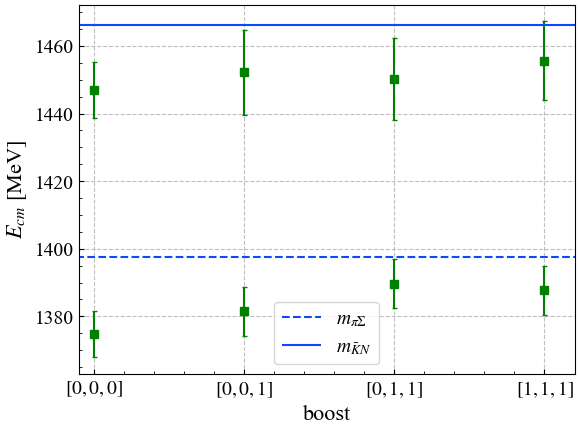

In [6]:
fig, ax = PyPlot.subplots()
plot_latt_ener_2level!(ax, _2lv, _2lv_err, latt_para[:threshold] )
ax.grid()
gcf()

In [7]:
function cost_fun!(latt_pole, latt_pole_err, params, Nv, fitted_para; dof=2,  fix_f=false)
    para = copy(params)
    if fix_f == true
        a1, a2, f, fπ = fitted_para
        
        para[:decons_vec] = [fπ fπ*f; fπ*f fπ]
    else
        a1, a2 = fitted_para
    end

    dd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        p = []
        df1 = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, para, [a1, a2], N), 1350, 1400, 1)
        df2 = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, para, [a1, a2], N), 1420, 1468, 1)
        x10 = df1.x0
        x20 = df2.x0

        if length(x10) == 1
            append!(p, x10)
        else
            append!(p, pole_finite_vol!(1380, para, [a1, a2], N))
        end
        
        if length(x20) == 1
            append!(p, x20)
        else
            append!(p, pole_finite_vol!(1466, para, [a1, a2], N) )
        end
        
        d = (pole - p) ./ pole_err
        dd += d' * d
        len += length(pole)
    end
    return dd / (len - dof)
end

Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]

#=
function makefit_finite_lo!(costfun, init_para)
    m = Minuit(costfun, init_para, limit_x0=(-5, -0.1), limit_x1=(-5, -0.1))
    m.strategy = 2
    migrad(m)
    migrad(m)
end
=#
#m = makefit_finite_lo!(f -> cost_fun!(_2lv, _2lv_err, params, Nv, f), [-1.6325762046840782, -1.7138485812778343])

makefit_finite_lo! (generic function with 1 method)

In [7]:
params = copy(latt_para)
f = 1.1999999988821624
fπ = 93

#params[:decons_vec] = [fπ fπ*f; fπ*f fπ]#[92.4, 92.4, 92.4, 92.4] .* 1.2
params[:decons_vec] = [fπ, 108e0]

2-element Vector{Float64}:
  93.0
 108.0

In [9]:
#a_fit = [m.values...]
 a_fit = [-1.6325807018101615, -1.7138494070912544]

2-element Vector{Float64}:
 -1.6325807018101615
 -1.7138494070912544

  1.360490 seconds (14.23 M allocations: 589.139 MiB, 6.21% gc time, 83.59% compilation time)


  0.466318 seconds (23.83 M allocations: 671.494 MiB, 13.63% gc time, 4.87% compilation time)


  0.436814 seconds (23.82 M allocations: 667.350 MiB, 12.85% gc time)


  0.437417 seconds (23.93 M allocations: 669.711 MiB, 12.29% gc time)


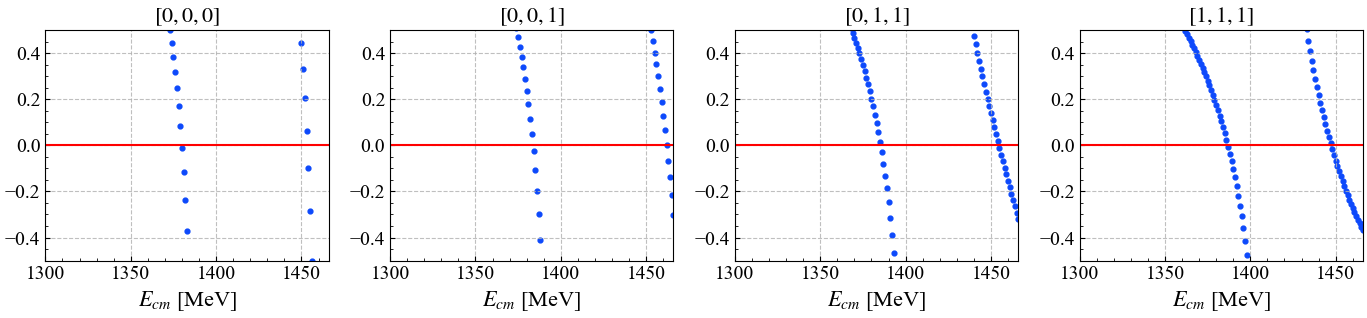

In [10]:
w = 1300:1:1466
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol!(ax[i], w, params, a_fit, G)
end
gcf()

In [11]:
@time bisection_internal_sol!(x -> tdet_finite_vol_params!(x, params, a_fit, [0, 1, 1]), 1350, 1466, 1)

  4.310398 seconds (57.89 M allocations: 1.977 GiB, 8.09% gc time, 78.53% compilation time)


Row,bis_inter,bis_x0,x0
,Any,Any,Any
1,"(1385, 1386)",1385.32,1385.32
2,"(1454, 1455)",1454.62,1454.62


In [12]:
function pole_finite_LO_2lv_bisection!(params, a, Nv)
    p = DataFrame([])
    columns = ["[0, 0, 0]", "[0, 0, 1]", "[0,1,1]", "[1,1,1]"]

    for (i, N) in enumerate(Nv)
        df = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, params, a, N), 1350, 1470, 1)
        x0 = df.x0
        p[!, columns[i] ] = x0
    end
    #pp = DataFrame(p, ["[0,0,0]", "[0,0,1]", "[0,1,1]", "[1,1,1]"])
    return p
end
df = pole_finite_LO_2lv_bisection!(params, a_fit, Nv)
pole = [df[1:2, i] for i in 1:4]
df

Row,"[0, 0, 0]","[0, 0, 1]","[0,1,1]","[1,1,1]"
,Any,Any,Any,Any
1,1379.89,1383.65,1385.32,1386.8
2,1453.41,1462.04,1454.62,1447.35


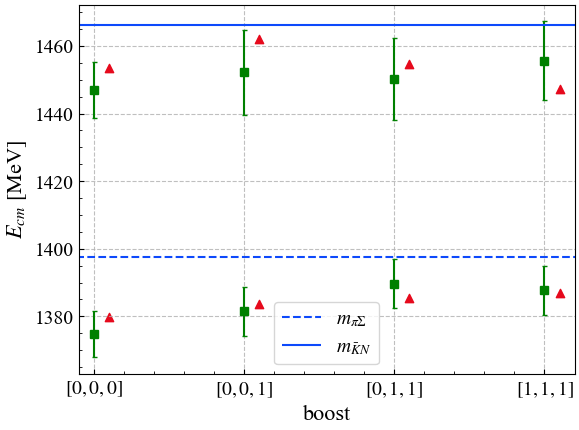

In [13]:
fig, ax = PyPlot.subplots()
plot_theory_ener_2level!(ax, pole)
plot_latt_ener_2level!(ax, _2lv, _2lv_err, latt_para[:threshold] )
ax.grid()
fig.savefig("./figure/two_energy_level_fitted.pdf")
gcf()

# 4 energy levels

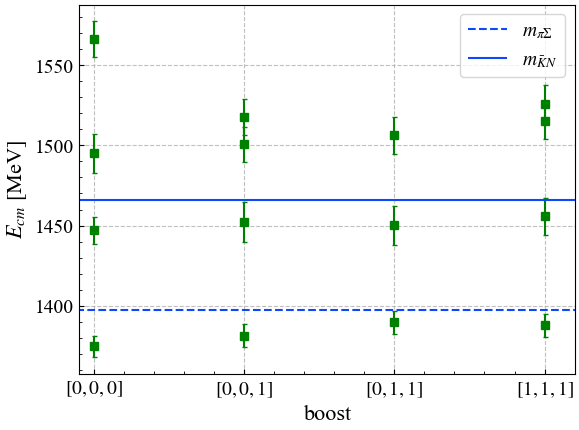

In [7]:
fig, ax = PyPlot.subplots()
#plot_theory_ener_2level!(ax, pole)
plot_latt_ener!(ax, latt_pole, latt_pole_err, latt_para[:threshold] )
ax.grid()
gcf()

We try to fit to all energy levels.

In [19]:
params = copy(latt_para )

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [13]:
function cost_fun!(latt_pole, latt_pole_err, params, Nv, fitted_para; dof=2,  same_f=true)
    para = copy(params)
    if same_f == true
        a1, a2, fπ, f = fitted_para
        
        para[:decons_vec] = [fπ, fπ] .* f
    else
        a1, a2 = fitted_para
    end

    dd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        x0 = N == [0, 0, 1] || N == [1, 1, 1] ? bisection_pole_finite_vol!(params, [a1, a2], N) : [pole_finite_vol!(init_x, para, [a1, a2], N) for init_x in pole]
        d = (pole - x0) ./ pole_err
        dd += d' * d
        len += length(pole)
    end
    return dd / (len - dof)
end

Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]


function makefit_finite_lo!(costfun, init_para)
    m = Minuit(costfun, init_para, fix_x1=true, fix_x2=true, limit_x3=(1.1, 1.2))
    m.strategy = 2
    migrad(m)
    migrad(m)
end
#-1.4606403424973218, -2.0
@time cost_fun!(latt_pole, latt_pole_err, params, Nv, [-1.85226, -2.0, 92.4, 1.123]; dof=4)

 13.531680 seconds (424.21 M allocations: 11.632 GiB, 9.74% gc time, 0.33% compilation time)


1.7841282058192638

In [18]:
function one_sigma_err_band!(costfun)
    a2 = -2.5:0.01:-1.84
    df = DataFrame([[] []], [:a1, :a2] )
    CSV.write("./out/one_sigma_LO.csv", df)
    
    for a in a2
        bounds = [(nothing, nothing), (a-1e-8, a+1e-8)]
        sol = opt.minimize(f -> costfun(latt_pole, latt_pole_err, params, Nv, f), [-1.4606403424973218, a], bounds=bounds, tol=1e-6, options=Dict("maxiter" => 100))
        if sol["fun"] < 2.5
            df = DataFrame(x0=[sol["x"][1]], x2=[sol["x"][2]], :auto)
            CSV.write("./out/one_sigma_LO.csv", df, append=true)
        else
            continue
        end
    end
end
#one_sigma_err_band!(cost_fun!)

one_sigma_err_band! (generic function with 1 method)

In [42]:
@time m = makefit_finite_lo!(xx -> cost_fun!(latt_pole, latt_pole_err, params, Nv, xx; dof=4), [-1.4863864137107967
-2.0
92.4
1.0955233539114262])

1061.088789 seconds (31.74 G allocations: 870.135 GiB, 13.42% gc time, 0.00% compilation time)


PyObject <FMin algorithm='Migrad' edm=4.775046673401837e-08 edm_goal=0.0002 errordef=1.0 fval=1.918202641531709 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=75 ngrad=0 reduced_chi2=nan time=-149.1388125430003>
(Param(number=0, name='x0', value=-1.7654359615983304, error=1.2324752238284185, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=-2.0, error=0.02, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=92.4, error=0.924, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='x3', value=1.1195546554926294, error=0.12657842873966274, merror=None, is_const=False, is_fixed=False, lower_limit=1.0, upper_limit=1.2))
[[ 1.51899518  0.          0.         -0.18726368]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.18726368  0.          0.          0.08631158]]

In [43]:
fpara = [m.values...]

4-element Vector{Float64}:
 -1.7654359615983304
 -2.0
 92.4
  1.1195546554926294

In [44]:
[m.errors...]

4-element Vector{Float64}:
 1.2324752238284185
 0.02
 0.924
 0.12657842873966274

In [55]:
params[:decons_vec] = [fpara[3], fpara[3], fpara[3], fpara[3]] .* fpara[4]
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [103.447, 103.447, 103.447, 103.447]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

  0.637668 seconds (15.70 M allocations: 513.095 MiB, 12.52% gc time, 10.23% compilation time)


  1.221629 seconds (35.70 M allocations: 1000.862 MiB, 13.10% gc time)


  1.235788 seconds (35.80 M allocations: 1002.962 MiB, 13.20% gc time)


  1.246373 seconds (35.95 M allocations: 1006.395 MiB, 13.13% gc time)


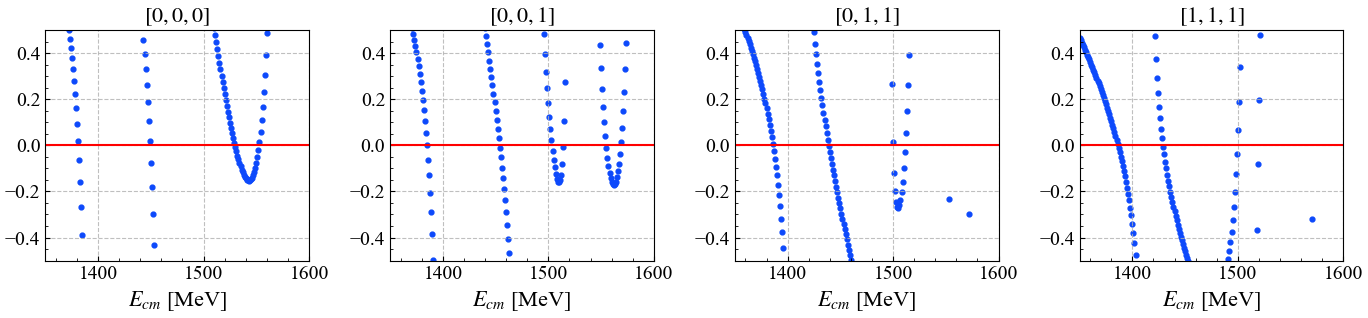

In [46]:
w = 1350:1:1600
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol!(ax[i], w, params, fpara[1:2], G)
end
gcf()

In [70]:
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [103.447, 103.447, 103.447, 103.447]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [47]:
df2 = pole_finite_vol_all_boost!(latt_pole, params, fpara[1:2], Nv)
pole2 = [df2[!, i] for i in 1:4]
df2

Row,"[0, 0, 0]","[0, 0, 1]","[0,1,1]","[1,1,1]"
,Float64,Float64,Float64,Any
1,1381.23,1384.99,1386.2,1386.4
2,1449.2,1453.77,1438.92,1428.85
3,1529.62,1503.47,1511.39,1499.38
4,1552.57,1514.09,NaN,1519.29


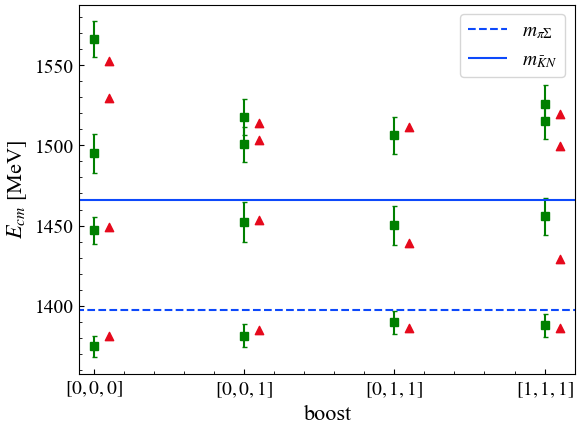

In [48]:
fig, ax = PyPlot.subplots()
plot_latt_ener!(ax, latt_pole, latt_pole_err, latt_para[:threshold] )
plot_theory_ener!(ax, pole2)
gcf()

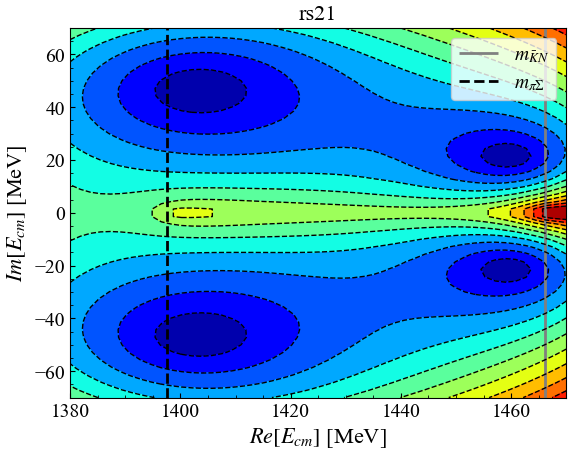

In [71]:
dim = 50
rew = range(1380, 1470, dim)
imw = range(-70, 70, dim)
a = [fpara[1:2]..., -2, -2]
fig, ax = PyPlot.subplots()
plot_tdet_LO!(ax, rew, imw, params, a, n=2, μ_tuple=(630e0,), rs="rs21")

gcf()